# Retinal Vascular Structure Segmentation in Retina Imagery

Author: **Marcin Sikorski**<br>
Date: June, 2025

#### Introduction

Retinal vessel segmentation plays an important role in the early detection and diagnosis of various retinal diseases, including diabetic retinopathy, glaucoma, and age-related macular degeneration. These conditions can lead to severe vision impairment or blindness if left untreated. However, identifying and accurately differentiating blood vessels is a complex task due to the intricate and varied nature of the retinal vascular network. The challenge is further compounded by the class imbalance in the dataset, where vessels often represent only a small portion of the entire retinal image, making the task of accurate segmentation even more difficult. Deep learning, particularly through convolutional neural networks (CNNs), have significantly improved the performance of retinal vessel segmentation. Techniques such as U-Net, a powerful architecture designed for pixel-level segmentation tasks, have shown great promise in accurately delineating blood vessels.

The motivation behind this project stems from the increasing need for automated systems that can assist healthcare professionals in diagnosing retinal diseases with greater precision and efficiency. Manual segmentation of retinal vessels is time-consuming, error-prone, and highly dependent on the skill of the clinician. This notebook will demonstrate an example of how such a system can be implemented.

**Keywords:** retina blood vessel image, deep learning, convolutional neural network, U-Net, pixel-level, imbalanced dataset, healthcare

#### Notebook Content:
1. Preprocessing Images and Splitting Data
2. Defining the Segmentation Model
3. Experimental Parameters
4. U-Net Training and Evaluation
5. Performing Examples
6. Conclusions

### 1. Preprocessing Images and Splitting Data

The notebook begins by preparing the environment for further work. All images and masks are loaded and preprocessed using helper functions to ensure compatibility with the U-Net model. The retina images are in RGB format, while their corresponding masks are binary. The dataset is available on [Kaggle](https://www.kaggle.com/datasets/ipythonx/retinal-vessel-segmentation) and is derived from DRIVE, STARE, and CHASE-DB1 datasets. The blood vessels in the images are considered the **foreground**, while the remaining regions are the **background**.

In [1]:
import os
# define framework for segmentation-models and log level for messages
os.environ['SM_FRAMEWORK'] = 'tf.keras'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# list of training images
input_dir = os.getcwd() + '/Data/train/image/'
IMAGES = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.png')
    ]
)

# list of training masks
target_dir = os.getcwd() + '/Data/train/mask/'
MASKS = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith('.png')
    ]
)

In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 12

# helper functions
def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.io.decode_gif(image)  # out: (1, height, width, 3)
        image = tf.squeeze(image)  # out: (height, width, 3)
        image = tf.image.rgb_to_grayscale(image)  # out: (height, width, 1)
        image = tf.divide(image, 128)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.int32)
    else:
        image = tf.image.decode_image(image, channels=4)  # out: (height, width, 4)
        image = image[:, :, :3]  # out: (height, width, 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.0  # normalize
    return image

def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

Our dataset is divided into two main folders: **train** and **test**. The **train** folder will be further split into three subsets in a 60/20/20 ratio:
* train data: this subset will be used for model training;
* validation data: this subset will be used to monitor the model's performance during training, helping to avoid overfitting;
* test data: this subset will be held out during training and will only be used after training to evaluate the performance of the final model.

The **test** data (second main folder) will act as unseen data to assess how well the trained segmentation model generalizes to new examples. It is strictly for evaluation and should not be used during training or validation.

In [4]:
from sklearn.model_selection import train_test_split

# first split: 60% for training, 40% for validation + test
train_images, val_test_images, train_masks, val_test_masks = train_test_split(
    IMAGES,
    MASKS,
    train_size=0.6,
    test_size=0.4,
    random_state=42,
    shuffle=True,
)

# second split: split the 40% validation + test into 50% validation and 50% test
val_images, test_images, val_masks, test_masks = train_test_split(
    val_test_images,
    val_test_masks,
    train_size=0.5,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)

# generate datasets
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)

### 2. Defining the Segmentation Model

We will implement the U-Net architecture using TensorFlow and Keras. The backbone, the underlying neural network architecture used for feature extraction (or pre-trained encoder), will be **EfficientNetB0**. For a binary classificaton the activation function will be **sigmoid**. The number of output classes is equal 1 → retinal pixels without background.

In [5]:
import segmentation_models as sm

# reset RAM and all state generated by Keras
keras.backend.clear_session()

# define U-Net
BACKBONE = 'efficientnetb0'
num_classes = 1
activation_function = 'sigmoid' if num_classes == 1 else 'softmax'

model = sm.Unet(
    BACKBONE,
    classes=num_classes,
    activation=activation_function,
    encoder_weights='imagenet',
)

# print architecture
#model.summary()

Segmentation Models: using `tf.keras` framework.



The following customized class will be used to monitor the behavior of the U-Net model during training. Every 50th epoch, it will visualize a random sample of the predicted mask and ground truth.

In [6]:
# visualization callback
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=50):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display_progress(self, display_list, extra_title=''):
        plt.figure(figsize=(6, 3))
        title = ['Original Image', 'Ground Truth Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i + 1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype('int32')
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display_progress([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print('\nSample prediction after epoch: {}\n'.format(epoch + 1))

### 3. Experimental Parameters

For the loss function, we can adapt binary cross-entropy (BCE) which should meet the requirements for a binary segmentation task. However, this time we will apply a more sophisticated loss function - focal Dice loss. This function unifies both focal cross-entropy loss and Dice loss. This loss function is designed to handle class imbalance and asymmetric losses. Focal loss is a variant of BCE (binary cross-entropy) and helps in detecting small structures in medical imaging. The Dice loss, inspired by Dice coefficient score, will calculate the similarity between two images. The performance of focal loss depends on carefully tuning two hyperparameters:
* $\alpha$ (alpha): a weight balancing factor for class 1, the weight for class is $1.0 - \alpha$;
* $\gamma$ (gamma): a focusing parameter used to modulate focal factor.

For retina vessel segmentation, we will accept:
* $\alpha$ = 0.25 → biases training toward the vessel class (foreground);
* $\gamma$ = 2.0 → good starting point for many binary segmentation tasks.

These values are used in many medical image segmentation studies and should help the model focus on the thin vessel structures, which are easily overwhelmed by the background otherwise. The `from_logits` argument should be False due to the fact that the model's final layer apply a sigmoid function (outputs probabilities between 0 and 1).

In [7]:
from keras.losses import BinaryFocalCrossentropy

# Dice loss
# add smoothing (numerical stability) to avoid division by zero
def dice_loss(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

# combine Dice + focal loss
class FocalDiceLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2., name='focal_dice_loss'):
        super(FocalDiceLoss, self).__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.focal = BinaryFocalCrossentropy(from_logits=False, alpha=self.alpha, gamma=self.gamma)
        
    def call(self, y_true, y_pred):
        focal_loss = self.focal(y_true, y_pred)
        dice = dice_loss(y_true, y_pred)
        return focal_loss + dice

In order to accurately evaluate the experimental results, the following indicators will be used in the training process:
* **accuracy**: not suitable and can be misleading for imbalanced datasets, but still gives a general view of classification;
* **IoU (Intersection over Union)**: displays the amount of overlapping between predicted mask and ground truth mask;
* **sensitivity (or recall)**: represents the true positive rate (TP) - % of positives correctly classified;
* **precision**: represents the proportion of positive predictions that are actually correct;
* **specificity**: represents the true negative rate (TN) - % of negatives correctly classified;
* **F1 score**: is the harmonic mean of precision and recall, Dice and F1 score are mathematically equivalent in binary classification tasks;
* **MCC (Matthew's correlation coefficient)**: suitable for performance measurement of binary classifications for two categories with different sizes (imbalanced datasets).

All these evaluation metrics can be described with following formulas:
$$\text{Accuracy} = \frac{\mathbf{TP} + \mathbf{TN}}{\mathbf{TP} + \mathbf{FP} + \mathbf{FN} + \mathbf{TN}}$$
$$\text{IoU} = \frac{\mathbf{TP}}{\mathbf{TP} + \mathbf{FP} + \mathbf{FN}}$$
$$\text{Sensitivity} = \frac{\mathbf{TP}}{\mathbf{TP} + \mathbf{FN}}$$
$$\text{Precision} = \frac{\mathbf{TP}}{\mathbf{TP} + \mathbf{FP}}$$
$$\text{Specificity} = \frac{\mathbf{TN}}{\mathbf{TN} + \mathbf{FP}}$$
$$\text{F1 Score} = \frac{2 \times \mathbf{Precision} \times \mathbf{Recall}}{\mathbf{Precision} + \mathbf{Recall}} = \frac{2\mathbf{TP}}{2\mathbf{TP} + \mathbf{FP} + \mathbf{FN}}$$
$$\text{MCC} = \frac{\mathbf{TP} \times \mathbf{TN} - \mathbf{FP} \times \mathbf{FN}}{\sqrt{(\mathbf{TP} + \mathbf{FP})(\mathbf{TP} + \mathbf{FN})(\mathbf{TN} + \mathbf{FP})(\mathbf{TN} + \mathbf{FN})}}$$

where TP, FP, TN and FN represent true positive, false positive, true negative and false negative, respectively. TP represents the vascular pixels predicted by the model as blood vessels, and FP represents the vascular pixels predicted by the model as background. TN represents the background pixel predicted by the model as the background, and FP represents the background pixel predicted by the model as the blood vessel.

In [8]:
# specificity (true negative rate)
def specificity(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tn / (tn + fp + smooth)

# F1 score (Dice coefficient)
def f1_score(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = 2 * precision * recall / (precision + recall + smooth)
    return f1

# Matthew's correlation coefficient
def mcc(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    numerator = (tp * tn) - (fp * fn)
    denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + smooth)

### 4. U-Net Training and Evaluation

The loss function and evaluation metrics are defined and will be used to assess model performance. The model will use Adam (Adaptive Moment Estimation) as the overall optimization. The learning rate will be set to 0.0001 for 210 epochs. The model's performance will be tracked during training using validation data. Finally, learning curves will be displayed, and the trained model will be evaluated on the test data.

Epoch 1/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 263s 31s/step - accuracy: 0.5824 - f1_score: 0.1040 - iou: 0.3134 - loss: 1.0867 - mcc: -0.0637 - precision: 0.0637 - recall: 0.2786 - specificity: 0.6112 - val_accuracy: 0.8250 - val_f1_score: 0.1795 - val_iou: 0.4620 - val_loss: 0.9825 - val_mcc: 0.0889 - val_precision: 0.1591 - val_recall: 0.2245 - val_specificity: 0.8909
Epoch 2/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 107s 27s/step - accuracy: 0.6558 - f1_score: 0.1675 - iou: 0.3674 - loss: 1.0285 - mcc: 0.0478 - precision: 0.1058 - recall: 0.3994 - specificity: 0.6801 - val_accuracy: 0.7083 - val_f1_score: 0.2452 - val_iou: 0.4165 - val_loss: 0.9968 - val_mcc: 0.1605 - val_precision: 0.1589 - val_recall: 0.5287 - val_specificity: 0.7382
Epoch 3/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 98s 25s/step - accuracy: 0.7040 - f1_score: 0.2295 - iou: 0.4100 - loss: 0.9900 - mcc: 0.1426 - precision: 0.1481 - recall: 0.5096 - specificity: 0.7224 - val_accuracy: 0.6292 - val_f1_score: 0.2465 - val_iou: 0.3723 - val_loss: 1.0054 

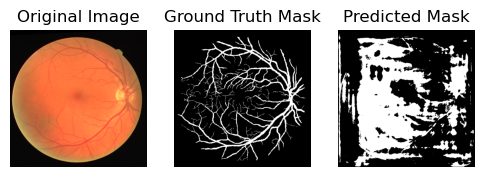


Sample prediction after epoch: 51

4/4 ━━━━━━━━━━━━━━━━━━━━ 114s 30s/step - accuracy: 0.9637 - f1_score: 0.8100 - iou: 0.8206 - loss: 0.5165 - mcc: 0.7944 - precision: 0.7402 - recall: 0.8942 - specificity: 0.9703 - val_accuracy: 0.7090 - val_f1_score: 0.2199 - val_iou: 0.4112 - val_loss: 1.2064 - val_mcc: 0.1239 - val_precision: 0.1470 - val_recall: 0.4712 - val_specificity: 0.7290
Epoch 52/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 104s 27s/step - accuracy: 0.9644 - f1_score: 0.8130 - iou: 0.8231 - loss: 0.5105 - mcc: 0.7976 - precision: 0.7445 - recall: 0.8953 - specificity: 0.9709 - val_accuracy: 0.7064 - val_f1_score: 0.2168 - val_iou: 0.4086 - val_loss: 1.2805 - val_mcc: 0.1208 - val_precision: 0.1441 - val_recall: 0.4638 - val_specificity: 0.7034
Epoch 53/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 105s 27s/step - accuracy: 0.9650 - f1_score: 0.8156 - iou: 0.8253 - loss: 0.5044 - mcc: 0.8004 - precision: 0.7486 - recall: 0.8957 - specificity: 0.9715 - val_accuracy: 0.7817 - val_f1_score: 0.2024 - val_iou: 

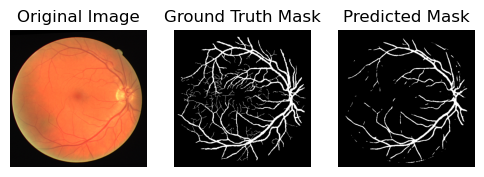


Sample prediction after epoch: 101

4/4 ━━━━━━━━━━━━━━━━━━━━ 107s 27s/step - accuracy: 0.9792 - f1_score: 0.8839 - iou: 0.8847 - loss: 0.2947 - mcc: 0.8731 - precision: 0.8550 - recall: 0.9148 - specificity: 0.9853 - val_accuracy: 0.9550 - val_f1_score: 0.7029 - val_iou: 0.7511 - val_loss: 0.5599 - val_mcc: 0.6902 - val_precision: 0.8360 - val_recall: 0.6163 - val_specificity: 0.9888
Epoch 102/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 101s 25s/step - accuracy: 0.9797 - f1_score: 0.8864 - iou: 0.8870 - loss: 0.2907 - mcc: 0.8758 - precision: 0.8590 - recall: 0.9156 - specificity: 0.9858 - val_accuracy: 0.9552 - val_f1_score: 0.6989 - val_iou: 0.7500 - val_loss: 0.5597 - val_mcc: 0.6887 - val_precision: 0.8473 - val_recall: 0.6072 - val_specificity: 0.9900
Epoch 103/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 100s 25s/step - accuracy: 0.9795 - f1_score: 0.8852 - iou: 0.8858 - loss: 0.2896 - mcc: 0.8745 - precision: 0.8571 - recall: 0.9151 - specificity: 0.9856 - val_accuracy: 0.9555 - val_f1_score: 0.7082 - val_io

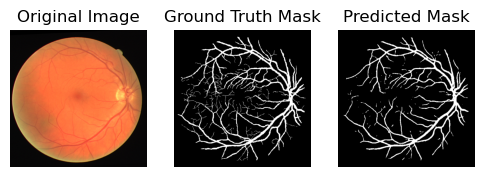


Sample prediction after epoch: 151

4/4 ━━━━━━━━━━━━━━━━━━━━ 101s 26s/step - accuracy: 0.9852 - f1_score: 0.9155 - iou: 0.9140 - loss: 0.1959 - mcc: 0.9075 - precision: 0.9024 - recall: 0.9289 - specificity: 0.9905 - val_accuracy: 0.9613 - val_f1_score: 0.7646 - val_iou: 0.7908 - val_loss: 0.3911 - val_mcc: 0.7467 - val_precision: 0.8248 - val_recall: 0.7181 - val_specificity: 0.9859
Epoch 152/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 95s 24s/step - accuracy: 0.9857 - f1_score: 0.9185 - iou: 0.9169 - loss: 0.1919 - mcc: 0.9108 - precision: 0.9054 - recall: 0.9321 - specificity: 0.9908 - val_accuracy: 0.9613 - val_f1_score: 0.7634 - val_iou: 0.7902 - val_loss: 0.3921 - val_mcc: 0.7459 - val_precision: 0.8298 - val_recall: 0.7126 - val_specificity: 0.9864
Epoch 153/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 96s 24s/step - accuracy: 0.9851 - f1_score: 0.9149 - iou: 0.9135 - loss: 0.1940 - mcc: 0.9069 - precision: 0.9030 - recall: 0.9272 - specificity: 0.9906 - val_accuracy: 0.9615 - val_f1_score: 0.7651 - val_iou:

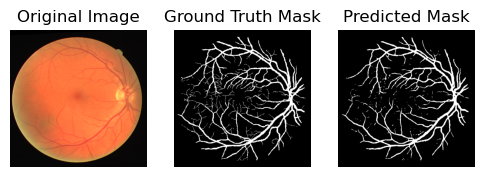


Sample prediction after epoch: 201

4/4 ━━━━━━━━━━━━━━━━━━━━ 104s 27s/step - accuracy: 0.9885 - f1_score: 0.9341 - iou: 0.9319 - loss: 0.1457 - mcc: 0.9278 - precision: 0.9275 - recall: 0.9408 - specificity: 0.9930 - val_accuracy: 0.9615 - val_f1_score: 0.7661 - val_iou: 0.7911 - val_loss: 0.3777 - val_mcc: 0.7486 - val_precision: 0.8315 - val_recall: 0.7134 - val_specificity: 0.9865
Epoch 202/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 99s 25s/step - accuracy: 0.9890 - f1_score: 0.9369 - iou: 0.9346 - loss: 0.1426 - mcc: 0.9309 - precision: 0.9290 - recall: 0.9449 - specificity: 0.9932 - val_accuracy: 0.9615 - val_f1_score: 0.7657 - val_iou: 0.7906 - val_loss: 0.3787 - val_mcc: 0.7484 - val_precision: 0.8336 - val_recall: 0.7104 - val_specificity: 0.9867
Epoch 203/210
4/4 ━━━━━━━━━━━━━━━━━━━━ 97s 25s/step - accuracy: 0.9892 - f1_score: 0.9379 - iou: 0.9356 - loss: 0.1417 - mcc: 0.9320 - precision: 0.9296 - recall: 0.9463 - specificity: 0.9932 - val_accuracy: 0.9616 - val_f1_score: 0.7669 - val_iou:

In [9]:
LEARNING_RATE = 1e-4
EPOCHS = 210

# define optimizer
adam_optimizer = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    name='adam',
    beta_1=0.9,
    beta_2=0.999,
)

# evaluation metrics
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')
iou = tf.keras.metrics.BinaryIoU(target_class_ids=(0, 1), name='iou')
sensitivity = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

# compile U-Net model with defined optimizer, loss, and metrics
model.compile(
    optimizer=adam_optimizer,
    loss=FocalDiceLoss(alpha=0.25, gamma=2.0),
    metrics=[accuracy, iou, sensitivity, precision, specificity, f1_score, mcc],
)

# train U-Net model
history = model.fit(
    train_dataset,
    callbacks=[DisplayCallback(train_dataset)],
    validation_data=val_dataset,
    epochs=EPOCHS,
)

# export model to serialized file
model.save('efficientnetb0_unet.keras')

In [10]:
from pandas import DataFrame

# export and display training results
df = DataFrame(history.history)

df.to_csv('efficientnetb0_history.csv', index=False)
df.tail().round(4)

,accuracy,f1_score,iou,loss,mcc,precision,recall,specificity,val_accuracy,val_f1_score,val_iou,val_loss,val_mcc,val_precision,val_recall,val_specificity
205,0.9893,0.9391,0.9368,0.1385,0.9333,0.9315,0.9470,0.9934,0.9615,0.7666,0.7911,0.3780,0.7491,0.8314,0.7136,0.9865
206,0.9893,0.9389,0.9366,0.1382,0.9331,0.9325,0.9455,0.9935,0.9614,0.7640,0.7894,0.3811,0.7470,0.8356,0.7062,0.9870
207,0.9896,0.9410,0.9386,0.1360,0.9353,0.9328,0.9493,0.9935,0.9616,0.7659,0.7909,0.3787,0.7488,0.8349,0.7103,0.9868
208,0.9892,0.9382,0.9359,0.1381,0.9323,0.9317,0.9449,0.9934,0.9616,0.7673,0.7919,0.3761,0.7494,0.8287,0.7175,0.9861
209,0.9889,0.9369,0.9346,0.1388,0.9308,0.9296,0.9443,0.9932,0.9613,0.7629,0.7885,0.3834,0.7462,0.8379,0.7021,0.9873


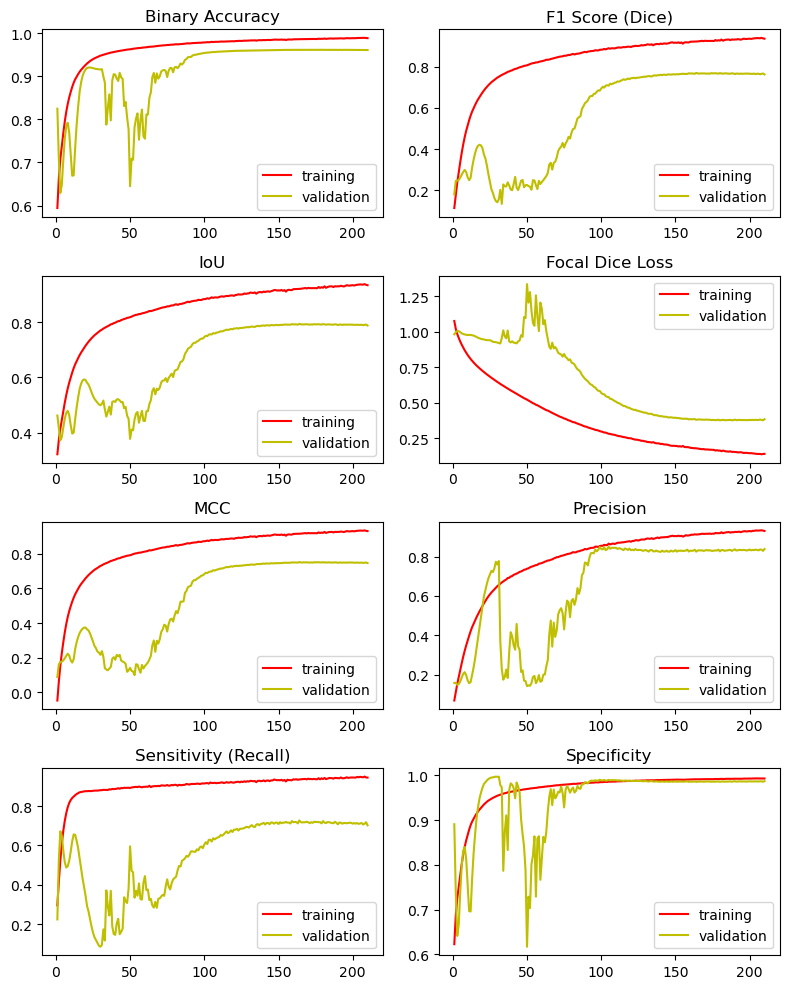

In [11]:
# extract the epochs and metrics to plot
epochs = range(1, len(df) + 1)
metrics = [
    'accuracy', 'f1_score', 'iou', 'loss',
    'mcc','precision', 'recall','specificity',
]
val_metrics = [
    'val_accuracy', 'val_f1_score', 'val_iou', 'val_loss',
    'val_mcc','val_precision', 'val_recall', 'val_specificity',
]
titles = [
    'Binary Accuracy', 'F1 Score (Dice)', 'IoU', 'Focal Dice Loss',
    'MCC', 'Precision', 'Sensitivity (Recall)', 'Specificity',
]

# plot learning curves
fig, axes = plt.subplots(4, 2, figsize=(8, 10))
axes = axes.flatten()

# loop through each metric and visualize it
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    ax.plot(epochs, df[metric], color='r', label='training')
    ax.plot(epochs, df[val_metrics[i]], color='y', label='validation')
    ax.set_title(title)
    #ax.set_xlabel('epochs')
    ax.legend()

plt.tight_layout()
plt.show()

The learning curves for the training dataset appear smooth and steady, indicating consistent model learning. The validation curves are initially jagged but stabilize midway through the epochs, which is a positive sign of generalization and improved performance on unseen data.

In [12]:
# evaluate U-Net on testing dataset and display metrics
eval_results = model.evaluate(
    test_dataset,
    verbose=1,
    batch_size=None,
    return_dict=True,
)

print('\n')
DataFrame([eval_results]).round(4)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 973ms/step - accuracy: 0.9626 - f1_score: 0.7686 - iou: 0.7931 - loss: 0.3721 - mcc: 0.7507 - precision: 0.8294 - recall: 0.7188 - specificity: 0.9858




,accuracy,f1_score,iou,loss,mcc,precision,recall,specificity
0,0.9627,0.7672,0.7928,0.3726,0.7494,0.8275,0.7191,0.9857


This model is overall highly accurate. Recall is slightly lower, meaning some small or faint vessels still might be missed. F1, IoU, and MCC are very strong, showing a solid model overall (especially for medical segmentation). Depending on clinical use, it would be desired to push recall higher.

### 5. Performing Examples

Now that the U-Net model is ready, we will run predictions on the selected retinal images. We will plot the predicted masks alongside the ground truth.

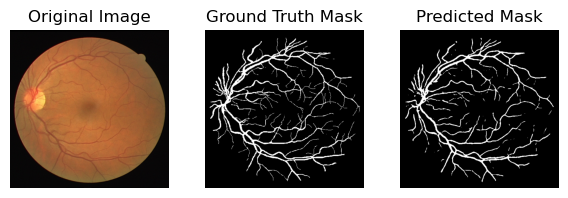

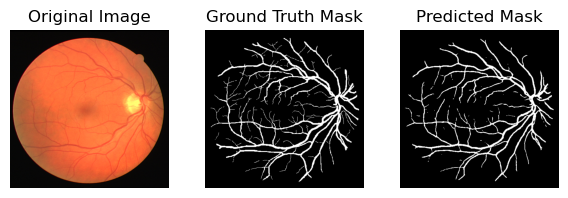

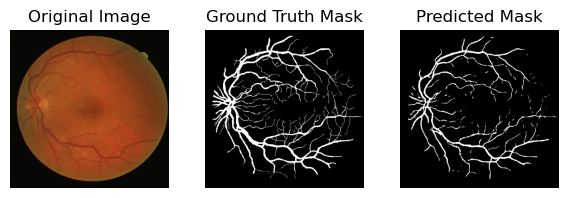

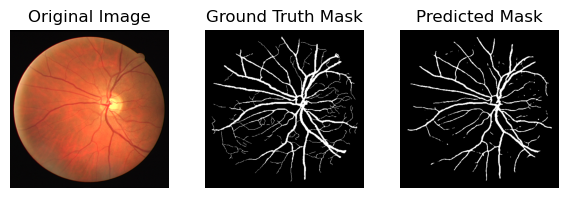

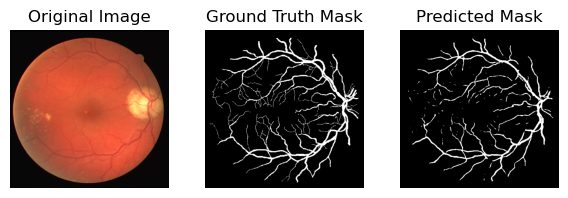

In [13]:
IMAGE_SIZE = 512
SELECTED_IMAGES = [
    os.path.join(os.getcwd(), f'Data/test/image/{i}.png')
    for i in [0, 1, 2, 3, 7]
]
SELECTED_MASKS  = [
    os.path.join(os.getcwd(), f'Data/test/mask/{i}.png')
    for i in [0, 1, 2, 3, 7]
]

# helper functions
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=4)  # out: (height, width, 4)
    image = image[:, :, :3]  # out: (height, width, 3)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image

def preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1)  # out: (height, width, 1)
    mask = tf.image.resize(mask, size=[IMAGE_SIZE, IMAGE_SIZE])
    mask = tf.cast(mask, tf.float32) / 255.0  # normalize
    mask = tf.where(mask >= 0.5, 1.0, 0.0)  # binarize
    return mask

def predict_single_image(model, image_path):
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)  # [1, 512, 512, 3]
    pred_mask = model.predict(image, verbose=0)[0]  # predict and remove batch
    pred_mask = tf.squeeze(pred_mask)  # [512, 512]
    return pred_mask

def threshold_mask(mask, threshold=0.5):
    return tf.cast(mask > threshold, tf.uint8)

# run on selected images
for image_path, mask_path in zip(SELECTED_IMAGES, SELECTED_MASKS):
    # generate masks
    pred_mask = predict_single_image(model, image_path)
    bin_mask = threshold_mask(pred_mask)
    true_mask = preprocess_mask(mask_path)

    # visualize segmentation results
    original_image = tf.keras.utils.load_img(image_path)
    
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(true_mask), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(bin_mask), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

The model segments vessels with good precision, particularly for the micro blood vessels. Visually, the masks are almost identical, with only slight omissions of micro vessels.

In order to evaluate the segmentation performance, we will apply the previous metrics. Rather than using standard accuracy, which can be misleading in imbalanced datasets, we will report balanced accuracy instead. Additionally, we include the following evaluation indicators:
* **balanced accuracy**: the average of recall (true positive rate) and specificity (true negative rate), making it particularly useful for imbalanced datasets;
* **Hausdorff distance**: measures the maximum distance from a point in one set (e.g., the predicted mask) to the closest point in the other set (e.g., the ground truth mask). It captures the worst-case spatial mismatch between two contours and is measured in pixels. It is the maximum distance of these asymmetric distances in both directions (from $A$ to $B$ and from $B$ to $A$);
* **FPR (false positive rate)**: the proportion of actual negative pixels that are incorrectly classified as positive - % of negatives misclassified as positives​;
* **FNR (false negative rate)**: the proportion of actual positive pixels that are incorrectly classified as negative - % of positives misclassified as negatives​.

These additional metrics can be described with following formulas:
$$\text{Balanced Accuracy} = \frac{1}{2}\left(\mathbf{Recall} + \mathbf{Specificity}\right) = \frac{1}{2}\left(\frac{\mathbf{TP}}{\mathbf{TP} + \mathbf{FN}} + \frac{\mathbf{TN}}{\mathbf{TN} + \mathbf{FP}}\right)$$
$$
\text{Hausdorff Distance} = \max \left\{ \sup_{a \in A} \inf_{b \in B} d(a, b),\ \sup_{b \in B} \inf_{a \in A} d(b, a) \right\}
$$
* $d(a, b)$: distance between points $a\in A$ and $b \in B$, typically Euclidean distance
* $\inf_{b \in B} d(a, b)$: distance from point $a$ to the closest point in $B$
* $\sup_{a \in A} \inf_{b \in B} d(a, b)$: the point in $A$ that is farthest from its nearest neighbor in $B$
$$\text{FPR} = 1 - \mathbf{Specificity} = \frac{\mathbf{FP}}{\mathbf{FP} + \mathbf{TN}}$$
$$\text{FNR} = 1 - \mathbf{Sensitivity} = \frac{\mathbf{FN}}{\mathbf{FN} + \mathbf{TP}}$$

The following code computes balanced accuracy, precision, and recall for each training image. Next, additional detailed evaluations will be conducted, including visual comparisons between the model's prediction and the ground truth mask.

In [14]:
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import balanced_accuracy_score, f1_score, jaccard_score
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score

# customized evaluation metrics (not all of them need to be used)
# balanced accuracy
def balanced_accuracy(y_true, y_pred, smooth=1e-7):
    y_true = np.ravel(y_true > 0.5)
    y_pred = np.ravel(y_pred > 0.5)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    recall = tp / (tp + fn + smooth)
    specificity = tn / (tn + fp + smooth)  
    return 0.5 * (recall + specificity)

# F1 score (Dice coefficient)
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# IoU
def iou_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# recall (sensitivity or true positive rate)
def custom_recall_score(y_true, y_pred, smooth=1e-7):
    y_true = np.ravel(y_true > 0.5)
    y_pred = np.ravel(y_pred > 0.5)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + smooth)

# specificity (true negative rate)
def specificity_score(y_true, y_pred, smooth=1e-7):
    y_true = np.ravel(y_true > 0.5)
    y_pred = np.ravel(y_pred > 0.5)
    
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tn / (tn + fp + smooth)

# Hausdorff distance
def hausdorff_distance(y_true, y_pred):
    y_true = np.squeeze(y_true > 0.5)
    y_pred = np.squeeze(y_pred > 0.5)
    
    true_points = np.argwhere(y_true)
    pred_points = np.argwhere(y_pred)
    
    if len(true_points) == 0 or len(pred_points) == 0:
        return np.nan
        
    hd1 = directed_hausdorff(true_points, pred_points)[0]
    hd2 = directed_hausdorff(pred_points, true_points)[0]
    return max(hd1, hd2)

# false positive rate
def false_positive_rate(y_true, y_pred, smooth=1e-7):
    # both inputs should be binary arrays
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    fp = np.logical_and(~y_true, y_pred).sum()
    tn = np.logical_and(~y_true, ~y_pred).sum()
    return fp / (fp + tn + smooth)

# false negative rate
def false_negative_rate(y_true, y_pred, smooth=1e-7):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return fn / (fn + tp + smooth)

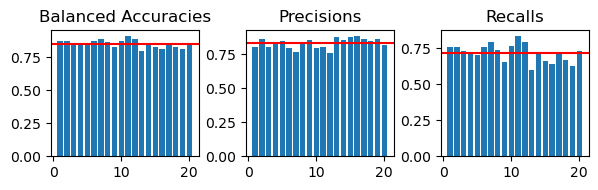

In [15]:
# list all training images
image_dir = os.path.join(os.getcwd(), 'Data/test/image')
ALL_IMAGES = [
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.endswith('.png')
]

# list all training masks
mask_dir = os.path.join(os.getcwd(), 'Data/test/mask')
ALL_MASKS  = [
    os.path.join(mask_dir, fname)
    for fname in os.listdir(mask_dir)
    if fname.endswith('.png')
]

bal_accs = []
recalls = []
precisions = []

# compute evaluation metrics
for image_path, mask_path in zip(ALL_IMAGES, ALL_MASKS):
    pred_mask = predict_single_image(model, image_path)
    bin_mask = tf.cast(threshold_mask(pred_mask), tf.float32)
    true_mask = preprocess_mask(mask_path)

    y_true_flat = np.ravel(true_mask.numpy() > 0.5)
    y_pred_flat = np.ravel(bin_mask.numpy() > 0.5)

    # list metrics
    bal_accs.append(balanced_accuracy_score(y_true_flat, y_pred_flat))
    precisions.append(precision_score(y_true_flat, y_pred_flat))
    recalls.append(recall_score(y_true_flat, y_pred_flat))

# visualize metrics for each image index and their averages
plt.figure(figsize=(6, 2))

plt.subplot(1, 3, 1)
plt.bar(range(1, 21), bal_accs)
plt.axhline(y=np.average(bal_accs), color='r', linestyle='-')
plt.title('Balanced Accuracies')

plt.subplot(1, 3, 2)
plt.bar(range(1, 21), precisions)
plt.axhline(y=np.average(precisions), color='r', linestyle='-')
plt.title('Precisions')

plt.subplot(1, 3, 3)
plt.bar(range(1, 21), recalls)
plt.axhline(y=np.average(recalls), color='r', linestyle='-')
plt.title('Recalls')

plt.tight_layout()
plt.show()

The accuracies and precisions have a fairly balanced distribution across all test images. The recalls fluctuate more, are less monotonous, and, ideally, should be higher for healthcare applications. This suggests that smaller vessels are still being missed. A linear correlation between balanced accuracies and recalls can be observed, as indicated by the bar height pattern.

Results for 0.png:
   Balanced Accuracy    : 0.8682
   F1 Score (Dice)      : 0.7782
   IoU                  : 0.6369
   MCC                  : 0.7578
   Precision            : 0.8035
   Hausdorff Distance   : 24.0832
   Recall (TPR)         : 0.7545
   Specificity (TNR)    : 0.9820
   FNR                  : 0.2455
   FPR                  : 0.0180
----------------------------------------


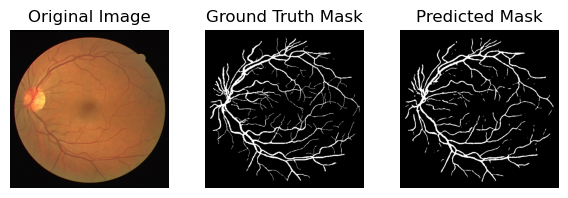

Results for 4.png:
   Balanced Accuracy    : 0.8243
   F1 Score (Dice)      : 0.7525
   IoU                  : 0.6032
   MCC                  : 0.7400
   Precision            : 0.8786
   Hausdorff Distance   : 39.0512
   Recall (TPR)         : 0.6580
   Specificity (TNR)    : 0.9906
   FNR                  : 0.3420
   FPR                  : 0.0094
----------------------------------------


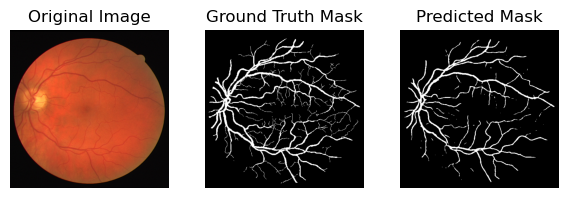

Results for 9.png:
   Balanced Accuracy    : 0.8586
   F1 Score (Dice)      : 0.7707
   IoU                  : 0.6270
   MCC                  : 0.7527
   Precision            : 0.8137
   Hausdorff Distance   : 41.7732
   Recall (TPR)         : 0.7321
   Specificity (TNR)    : 0.9851
   FNR                  : 0.2679
   FPR                  : 0.0149
----------------------------------------


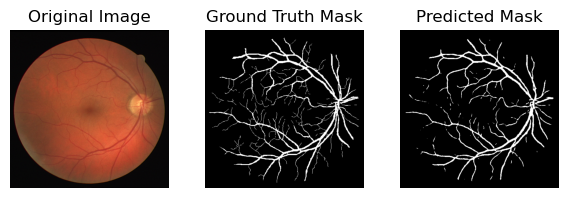

Results for 14.png:
   Balanced Accuracy    : 0.8871
   F1 Score (Dice)      : 0.7776
   IoU                  : 0.6361
   MCC                  : 0.7604
   Precision            : 0.7628
   Hausdorff Distance   : 33.5410
   Recall (TPR)         : 0.7930
   Specificity (TNR)    : 0.9812
   FNR                  : 0.2070
   FPR                  : 0.0188
----------------------------------------


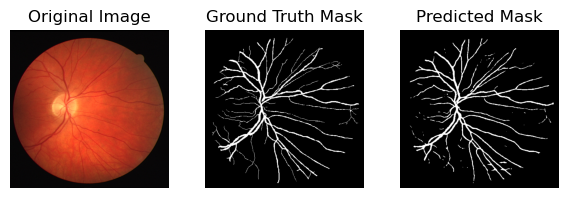

Results for 18.png:
   Balanced Accuracy    : 0.9061
   F1 Score (Dice)      : 0.8167
   IoU                  : 0.6903
   MCC                  : 0.8000
   Precision            : 0.8034
   Hausdorff Distance   : 26.1725
   Recall (TPR)         : 0.8305
   Specificity (TNR)    : 0.9816
   FNR                  : 0.1695
   FPR                  : 0.0184
----------------------------------------


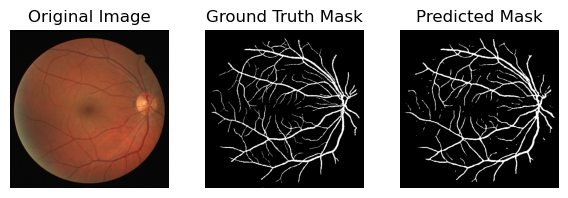

In [16]:
SELECTED_IMAGES = [
    os.path.join(os.getcwd(), f'Data/test/image/{i}.png')
    for i in [0, 4, 9, 14, 18]
]
SELECTED_MASKS = [
    os.path.join(os.getcwd(), f'Data/test/mask/{i}.png')
    for i in [0, 4, 9, 14, 18]
]

# run on selected images
for image_path, mask_path in zip(SELECTED_IMAGES, SELECTED_MASKS):
    # generate masks
    pred_mask = predict_single_image(model, image_path)
    bin_mask = tf.cast(threshold_mask(pred_mask), tf.float32)
    true_mask = preprocess_mask(mask_path)

    # convert to 0/1 and flatten
    y_true_flat = np.ravel(true_mask.numpy() > 0.5)
    y_pred_flat = np.ravel(bin_mask.numpy() > 0.5)
    
    # compute metrics
    bal_acc = balanced_accuracy_score(y_true_flat, y_pred_flat)
    dice = f1_score(y_true_flat, y_pred_flat)
    jac = jaccard_score(y_true_flat, y_pred_flat)  # equivalent to IoU
    mcc = matthews_corrcoef(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat)
    h_dis = hausdorff_distance(true_mask, bin_mask)
    rec = recall_score(y_true_flat, y_pred_flat)
    spec = specificity_score(y_true_flat, y_pred_flat)
    fnr = false_negative_rate(y_true_flat, y_pred_flat)
    fpr = false_positive_rate(y_true_flat, y_pred_flat)

    print(f'Results for {os.path.basename(image_path)}:')
    print(f'   Balanced Accuracy    : {bal_acc:.4f}')
    print(f'   F1 Score (Dice)      : {dice:.4f}')
    print(f'   IoU                  : {jac:.4f}')
    print(f'   MCC                  : {mcc:.4f}')
    print(f'   Precision            : {prec:.4f}')
    print(f'   Hausdorff Distance   : {h_dis:.4f}')
    print(f'   Recall (TPR)         : {rec:.4f}')
    print(f'   Specificity (TNR)    : {spec:.4f}')
    print(f'   FNR                  : {fnr:.4f}')
    print(f'   FPR                  : {fpr:.4f}')
    print('-' * 40)

    # visualize segmentation results
    original_image = tf.keras.utils.load_img(image_path)
    
    plt.figure(figsize=(6, 2))
    for i, (title, img) in enumerate([
        ('Original Image', original_image),
        ('Ground Truth Mask', tf.squeeze(true_mask)),
        ('Predicted Mask', tf.squeeze(bin_mask))
    ]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray' if i > 0 else None)
        plt.title(title)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

| **Metric**                  | 0.png   | 4.png   | 9.png   | 14.png  | 18.png  |
|-----------------------------|---------|---------|---------|---------|---------|
| **Balanced Accuracy**       | 0.8682  | 0.8243  | 0.8586  | 0.8871  | 0.9061  |
| **F1 Score (Dice)**         | 0.7782  | 0.7525  | 0.7707  | 0.7776  | 0.8167  |
| **IoU**                     | 0.6369  | 0.6032  | 0.6270  | 0.6361  | 0.6903  |
| **MCC**                     | 0.7578  | 0.7400  | 0.7527  | 0.7604  | 0.8000  |
| **Precision**               | 0.8035  | 0.8786  | 0.8137  | 0.7628  | 0.8034  |
| **Recall (TPR)**            | 0.7545  | 0.6580  | 0.7321  | 0.7930  | 0.8305  |
| **Specificity (TNR)**       | 0.9820  | 0.9906  | 0.9851  | 0.9812  | 0.9816  |
| **Hausdorff Distance [px]** |   24    |   39    |   42    |   34    |   26    |
| **FNR**                     | 0.2455  | 0.3420  | 0.2679  | 0.2070  | 0.1695  |
| **FPR**                     | 0.0180  | 0.0094  | 0.0149  | 0.0188  | 0.0184  |

The evaluation results for the binary retina segmentation task are quite promising overall (visually and numerically), especially for a medical imaging application where both precision and recall are critical. We can observe the following details and general conclusions:

✅ **Strengths**
* Balanced accuracy is consistently high, indicating good performance across both positive and negative classes, even in potentially imbalanced data.
* F1 scores suggest that the U-Net model is capturing a solid balance between precision and recall, with generally good overlap between predicted and ground truth masks.
* Precision is particularly strong, which means the model is producing relatively few false positives, an important aspect in clinical contexts where over-segmentation might lead to unnecessary concern.
* MCC values are solid, further validating overall prediction quality.
* Specificity (TNR) is exceptionally high in all cases, showing that negative regions (non-retina areas) are almost always correctly identified.

⚠️ **Areas to Work On**
* Recall (TPR) fluctuates more. A lower recall indicates that some actual retinal pixels are being missed, especially in `4.png`.
* Hausdorff distance varies significantly from 24 to 42 pixels. Higher values point to some worst-case boundary errors. An additional visual investigation would be recommended.
* FNR (false negative rate) is the complement of recall, and higher values here (up to 0.3420) suggest under-segmentation in some samples.

The model demonstrates robust and reliable performance, with balanced metrics that suggest it generalizes well across different images. High specificity and precision make the model trustworthy in not generating false alarms. This is important in sensitive medical diagnostics. While recall and Hausdorff distance leave some room for refinement, especially in certain edge cases, the overall segmentation quality remains strong. Improvements in boundary prediction (as suggested by Hausdorff and TPR) could yield even more clinically acceptable results.

### 6. Conclusions

Retinal blood vessel segmentation is a complex task due to the inconsistent shape and size of vessels at different levels of image granularity, as well as their tendency to bend, branch, and intersect in varied configurations. Additionally, the presence of class imbalance further complicates the task. Developing deep learning algorithms capable of accurately identifying microvessels is of critical importance, as it can significantly support and enhance physicians' diagnostic capabilities.

This notebook presents a U-Net-based neural network architecture with an EfficientNetB0 backbone for accurate, pixel-level segmentation of retinal blood vessels. Experiments conducted on the dataset demonstrate the effectiveness of the proposed approach, showing that the model is both robust and applicable to medical imaging tasks.

While the results are promising, particularly in segmenting fine vessel structures, there remains potential for further improvement. Future work may focus on refining microvessel detection, addressing class imbalance more effectively, and exploring attention mechanisms and different architectures to further boost performance and generalizability in real-world clinical settings. Enhancing the precision and robustness of retinal vessel segmentation could lead to better disease monitoring, more accurate diagnoses, and ultimately, improved patient outcomes.

**References:**
* C. Guo, M. Szemenyei, Y. Yi, W. Wang, B. Chen, C. Fan, 2020, *SA-UNet: Spatial Attention U-Net for Retinal Vessel Segmentation*, [Full Text](https://arxiv.org/pdf/2004.03696)
* Z. Liu, 2019, *Retinal Vessel Segmentation Based on Fully Convolutional Networks*, [Full Text](https://arxiv.org/pdf/1911.09915)
* R. Yang, S. Zhang, 2024, *Enhancing Retinal Vascular Structure Segmentation in Images With a Novel Design Two-Path Interactive Fusion Module Model*, [Full Text](https://arxiv.org/pdf/2403.01362v1)
* M. Yeung, E. Sala, C.B. Schönlieb d, L. Rundo, 2022, *Unified Focal loss: Generalising Dice and cross entropy-based losses to handle class imbalanced medical image segmentation*, [Full Text](https://www.sciencedirect.com/science/article/pii/S0895611121001750)